## Simulations: Dependent Data with No Interactions
This second simulation is also a sanity check for our main effect values. If the data has correlations but the output is still linear, then there should still be no interaction effects because the model has no interactions! The goal is to capture non-linear interactions in the model, not correlations in the data.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
import shap

import plot
from marginal import MarginalExplainer

In [2]:
n = 3000
d = 20
batch_size = 50
learning_rate = 0.05

In [3]:
W = np.random.uniform(-5, 5, d)
b = 0.0
mu = np.zeros(d)
cov = np.random.uniform(low=-2.0/np.sqrt(d), high=2.0/np.sqrt(d), size=(d, d))
cov = np.dot(cov, cov.T)

X = np.random.multivariate_normal(mu, cov, size=n)
y = np.dot(X, W) + b

In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(d,), batch_size=batch_size))
model.add(tf.keras.layers.Dense(1, activation=None, use_bias=False))

In [5]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MSE,
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])

In [6]:
model.fit(X, y, epochs=10, verbose=2)

Train on 3000 samples
Epoch 1/10
3000/3000 - 0s - loss: 14.2200 - mean_absolute_error: 2.0921 - mean_squared_error: 14.2200
Epoch 2/10
3000/3000 - 0s - loss: 0.4505 - mean_absolute_error: 0.5201 - mean_squared_error: 0.4505
Epoch 3/10
3000/3000 - 0s - loss: 0.1019 - mean_absolute_error: 0.2492 - mean_squared_error: 0.1019
Epoch 4/10
3000/3000 - 0s - loss: 0.0316 - mean_absolute_error: 0.1391 - mean_squared_error: 0.0316
Epoch 5/10
3000/3000 - 0s - loss: 0.0109 - mean_absolute_error: 0.0818 - mean_squared_error: 0.0109
Epoch 6/10
3000/3000 - 0s - loss: 0.0042 - mean_absolute_error: 0.0509 - mean_squared_error: 0.0042
Epoch 7/10
3000/3000 - 0s - loss: 0.0018 - mean_absolute_error: 0.0338 - mean_squared_error: 0.0018
Epoch 8/10
3000/3000 - 0s - loss: 9.6483e-04 - mean_absolute_error: 0.0247 - mean_squared_error: 9.6483e-04
Epoch 9/10
3000/3000 - 0s - loss: 6.1340e-04 - mean_absolute_error: 0.0197 - mean_squared_error: 6.1340e-04
Epoch 10/10
3000/3000 - 0s - loss: 4.6040e-04 - mean_absolut

In [7]:
num_shap_samples = 100

In [8]:
primal_explainer = MarginalExplainer(model, X[num_shap_samples:], nsamples=800, representation='mobius')
primal_effects = primal_explainer.explain(X[:num_shap_samples], verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W1023 10:40:30.883519 139858812094272 base_layer.py:1814] Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


In [9]:
dual_explainer = MarginalExplainer(model, X[num_shap_samples:], nsamples=800, representation='comobius')
dual_effects = dual_explainer.explain(X[:num_shap_samples], verbose=True)

100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


In [10]:
average_explainer = MarginalExplainer(model, X[num_shap_samples:], nsamples=800, representation='average')
average_effects = average_explainer.explain(X[:num_shap_samples], verbose=True)

100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


In [11]:
model_func = lambda x: model(x).numpy()
kernel_explainer = shap.SamplingExplainer(model_func, X)
kernel_shap = kernel_explainer.shap_values(X[:num_shap_samples])

In [12]:
def unroll(x):
    ret = []
    for i in range(x.shape[-1]):
        ret.append(x[:, i])
    return np.concatenate(ret)

In [13]:
data_df = pd.DataFrame({
    'Sampled Primal Effects':  unroll(primal_effects),
    'Sampled Dual Effects':    unroll(dual_effects),
    'Sampled Average Effects': unroll(average_effects),
    'Kernel SHAP Values':      unroll(kernel_shap),
    'Primal Interaction Effects':  unroll(kernel_shap - primal_effects),
    'Dual Interaction Effects':    unroll(kernel_shap - dual_effects),
    'Average Interaction Effects': unroll(kernel_shap - average_effects),
    'Feature': [int(i / num_shap_samples) for i in range(num_shap_samples * d)],
    'Feature Value': unroll(X[:num_shap_samples])
})

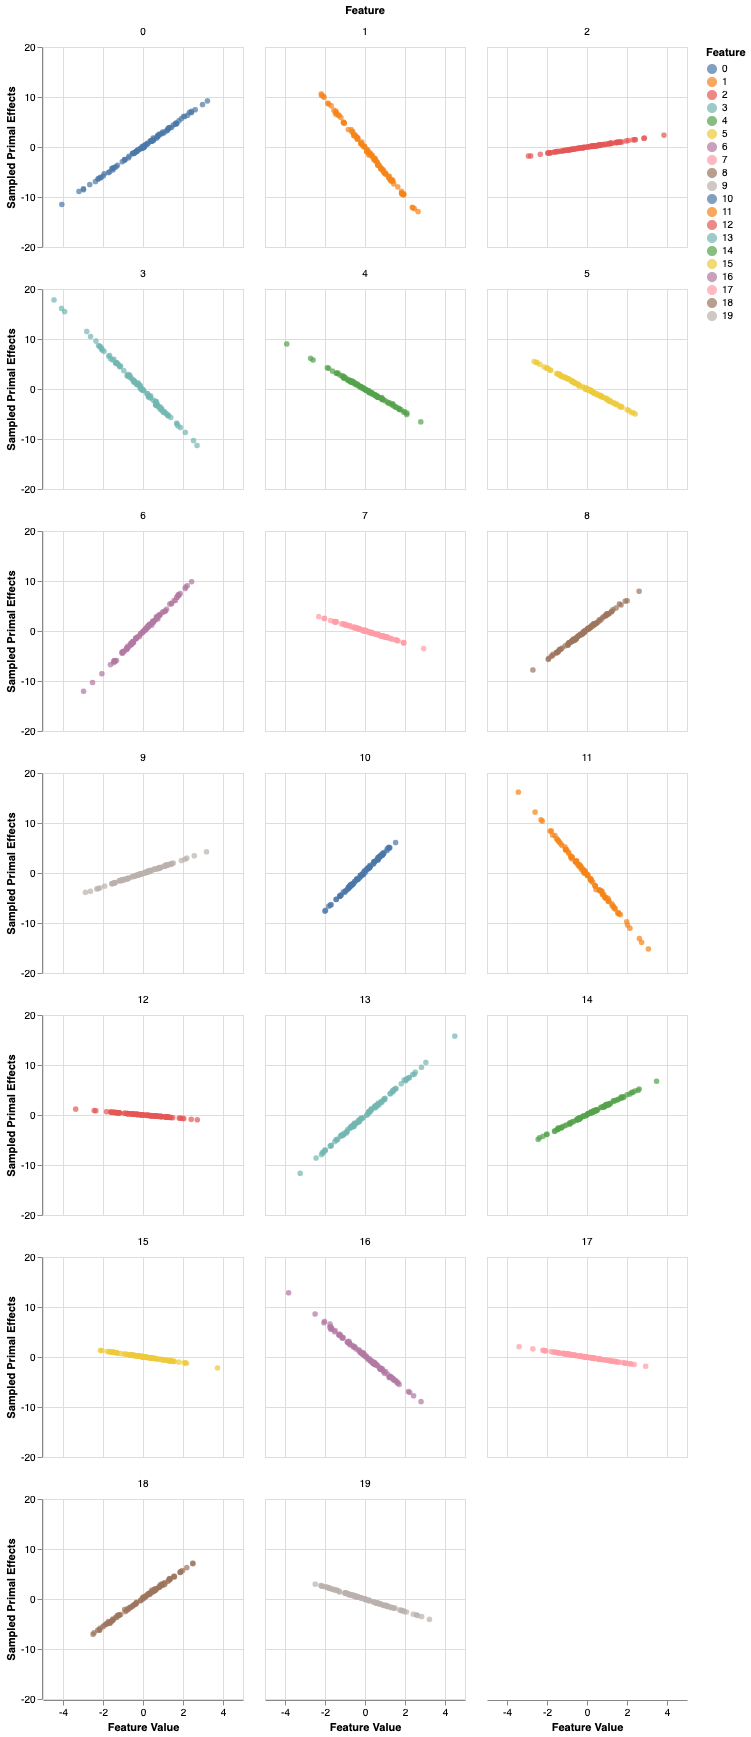

In [14]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.Y('Sampled Primal Effects:Q'),
    alt.X('Feature Value:Q'),
    alt.Color('Feature:N'),
    alt.Facet('Feature:N')
).properties(
    columns=3,
    width=200,
    height=200
)

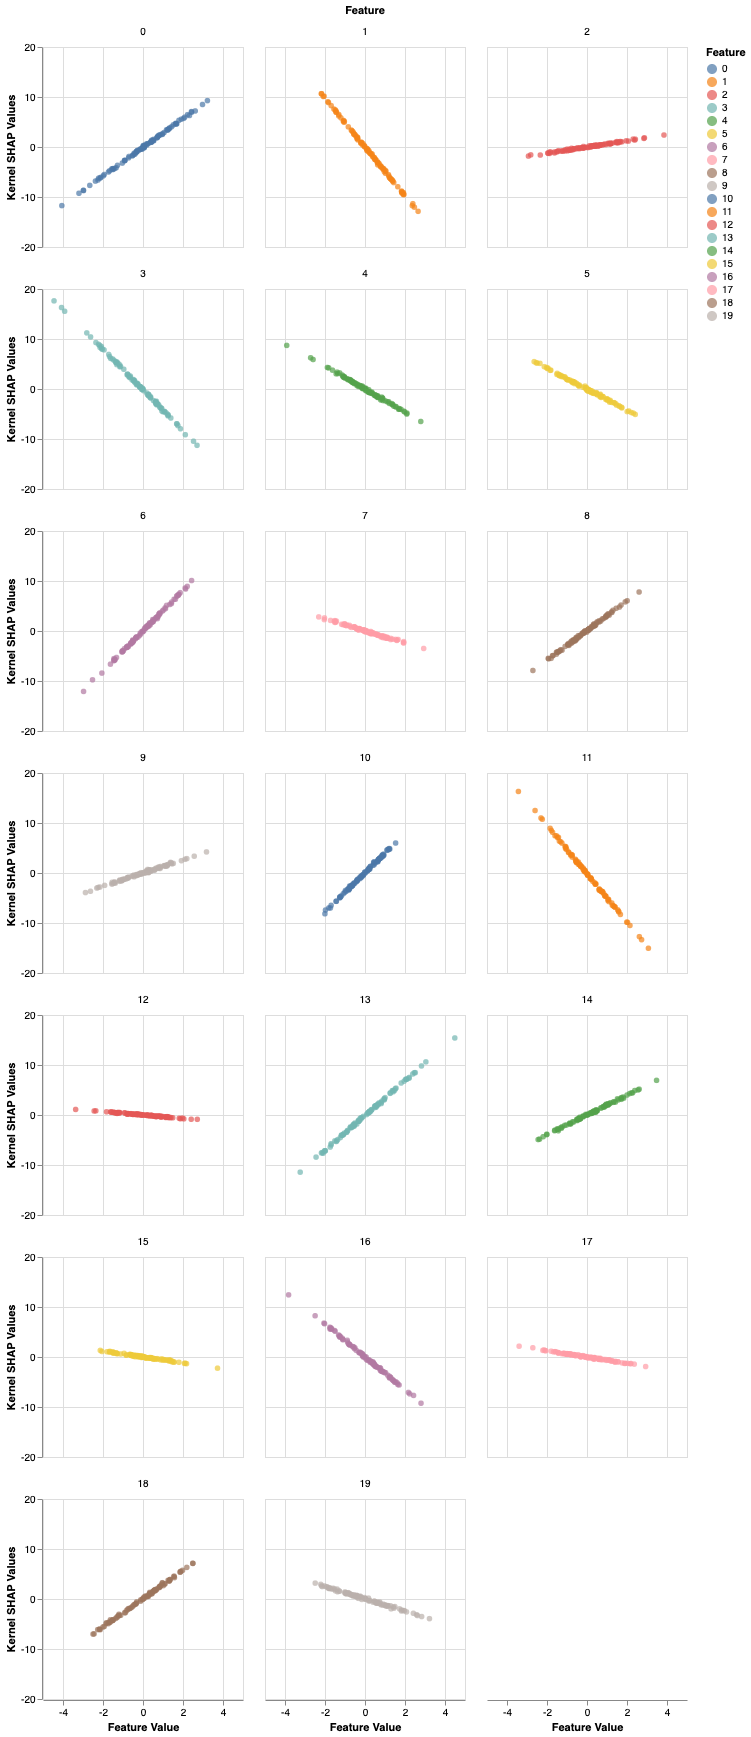

In [15]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.Y('Kernel SHAP Values:Q'),
    alt.X('Feature Value:Q'),
    alt.Color('Feature:N'),
    alt.Facet('Feature:N')
).properties(
    columns=3,
    width=200,
    height=200
)

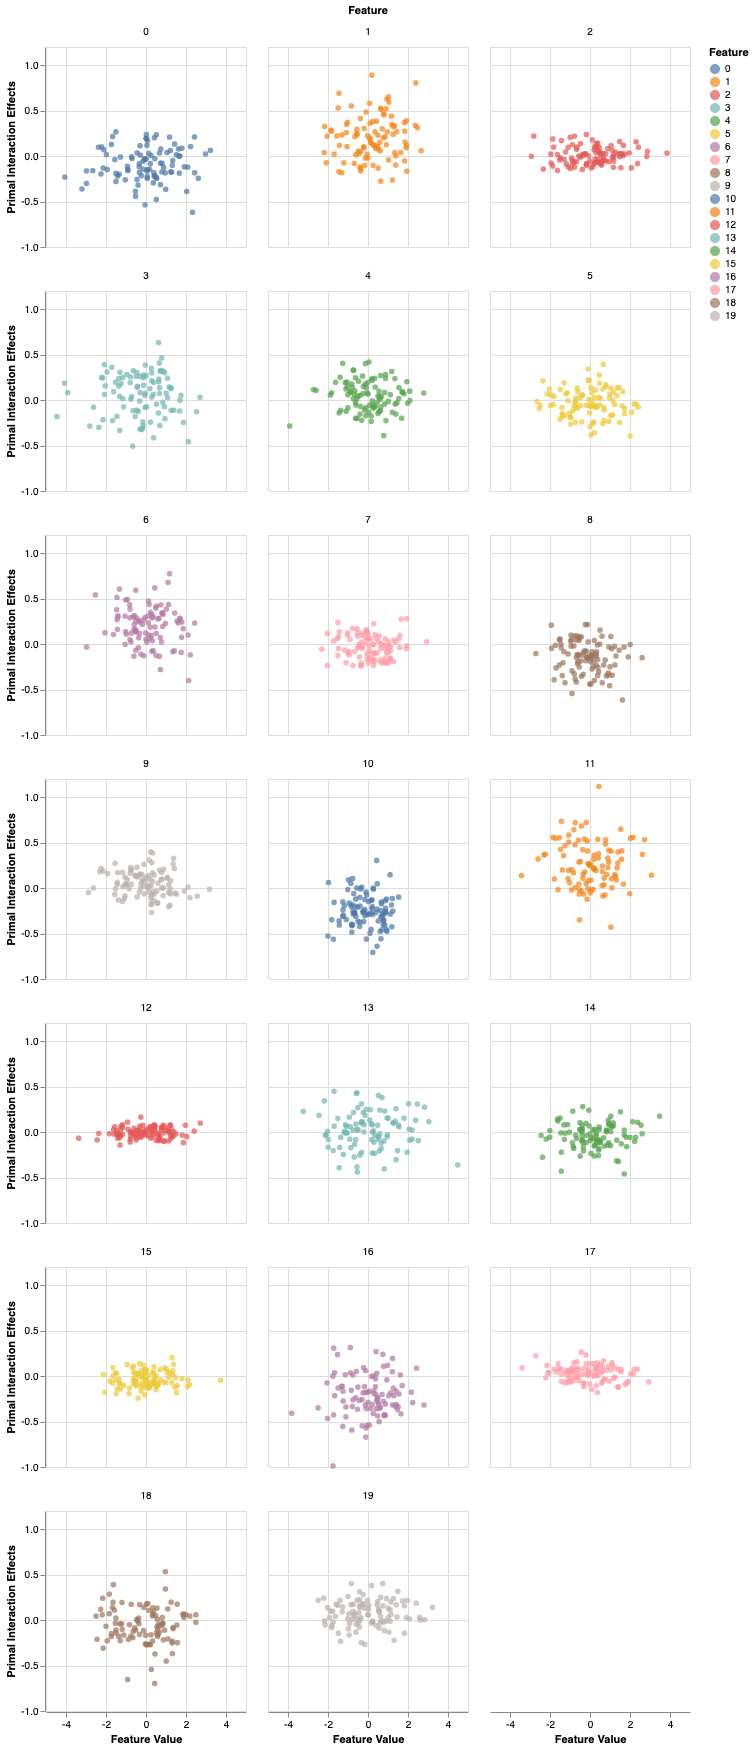

In [16]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.Y('Primal Interaction Effects:Q'),
    alt.X('Feature Value:Q'),
    alt.Color('Feature:N'),
    alt.Facet('Feature:N')
).properties(
    columns=3,
    width=200,
    height=200
)

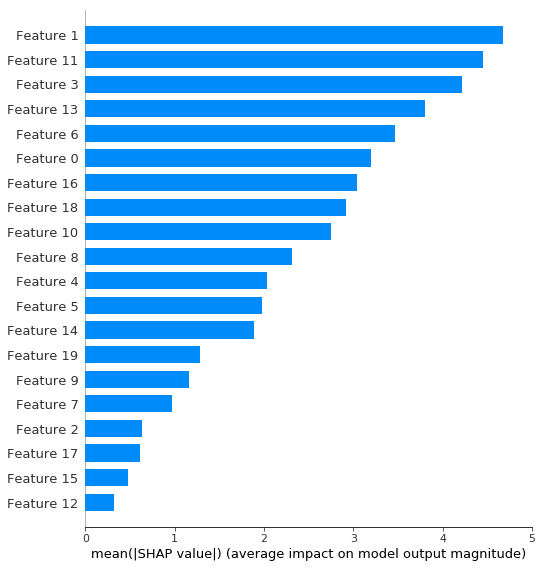

In [23]:
plot.summary_plot(kernel_shap, X[:num_shap_samples], plot_type='bar', xlim=(0.0, 5.0))

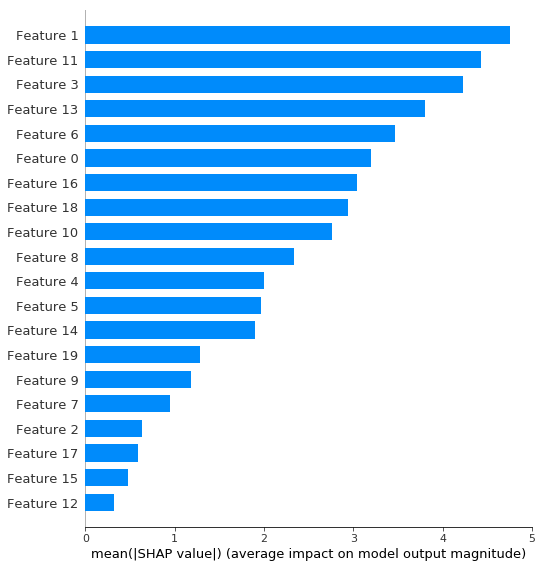

In [24]:
plot.summary_plot(primal_effects, X[:num_shap_samples], plot_type='bar', xlim=(0.0, 5.0))

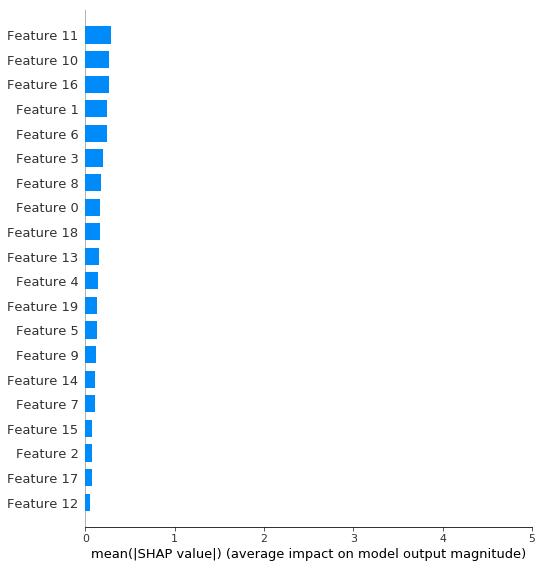

In [25]:
plot.summary_plot(kernel_shap - primal_effects, X[:num_shap_samples], plot_type='bar', xlim=(0.0, 5.0))

In [20]:
ind_df = pd.DataFrame({
    'Primal Main Effect': primal_effects[0],
    'Interaction Effect': kernel_shap[0] - primal_effects[0],
    'Feature': np.arange(kernel_shap.shape[1])
})

melted_df = pd.melt(ind_df, id_vars=['Feature'], value_name='Kernel SHAP Value', var_name='Effect Type')

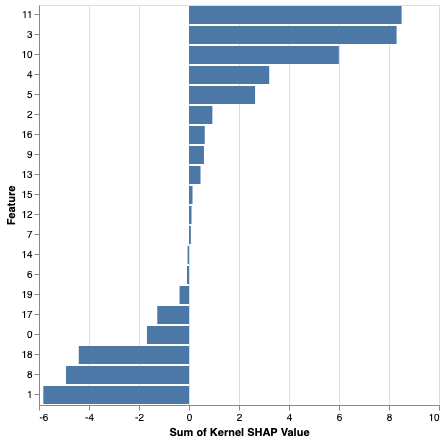

In [21]:
alt.Chart(melted_df).mark_bar().encode(
    alt.X('sum(Kernel SHAP Value):Q'),
    alt.Y('Feature:N', sort=alt.EncodingSortField(
            field="Kernel SHAP Value",
            order="descending" 
        ))
)

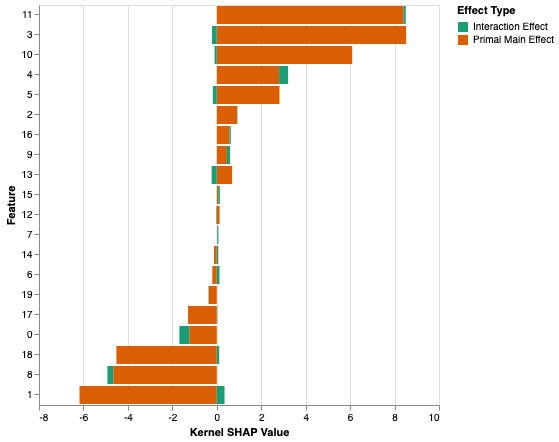

In [22]:
alt.Chart(melted_df).mark_bar().encode(
    alt.X('Kernel SHAP Value:Q'),
    alt.Y('Feature:N', sort=list(np.argsort(kernel_shap[0])[::-1])),
    alt.Color('Effect Type:N', scale=alt.Scale(scheme='dark2'))
)